- Imported libraries 
- Imported dataset 
- Created svm classifier

In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


- Used KDTree for finding the closest point
- Rewrote the optimal_point function around KDTree

In [5]:
from scipy.spatial import KDTree

# Function to find closest point to contour from the non healthy point
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

# Displacement from A to B 

- We added ```move_from_A_to_B_with_x1_displacement``` to the ```optimal_point()``` function

In [6]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / D  # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.5 0.5 0.5]
[3 3 3]
New point P with desired x1 movement: [2.5 3.5 4.5]


In [7]:
from scipy.interpolate import interp1d

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model): 
    x_in = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx1.shape)
    bound_data = []
    contour = plt.contour(xx1, xx2, y_pred, colors='red')
    for collection in contour.collections[:1]:
        for path in collection.get_paths():
            vertices = path.vertices
            x_coords = vertices[:, 0]
            y_coords = vertices[:, 1]
            bound_data.extend(zip(x_coords,y_coords))
    boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
    return boundary_df

# Gets boundary points
def boundary_points(xx1, xx2, model): 
    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

def get_border_points(x, y, delta_x, delta_y, step=0.1):
    points = []        
    
    # Define the boundaries
    x_min, x_max = x - delta_x, x + delta_x
    y_min, y_max = y - delta_y, y + delta_y

    # Generate points along the four edges
    for i in np.arange(x_min, x_max + step, step):
        points.append((i, y_min))  # Bottom edge
        points.append((i, y_max))  # Top edge

    for j in np.arange(y_min, y_max + step, step):
        points.append((x_min, j))  # Left edge
        points.append((x_max, j))  # Right edge

    # Remove duplicates (corner points get added twice)
    points = list(set(points))
    
    return points


# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def  optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, change_px=None, change_py=None): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 200000
    lower_boundx, upper_boundx = np.min(bound_x), np.max(bound_x)
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(lower_boundx, upper_boundx, N)[:, np.newaxis]
    Y_pred = f(X_pred)
    lower_boundy, upper_boundy = np.min(Y_pred), np.max(Y_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    if desired_class == 1: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        x,y = undesired_datapt[0], undesired_datapt[1]
        delta_x, delta_y = None, None 
        closest_boundedpt = None
        if (change_px is None and change_py is None) or (change_px == 'inf' and change_py == 'inf'): 
            raise TypeError("change_px and change_py are both None")
        elif change_px is None or change_px == 'inf': 
            delta_y = (change_py/100)*y
            print(delta_y)
            lowb_y, highb_y = max(y - (delta_y / 2), lower_boundy), min(y + (delta_y / 2), upper_boundy)
            print("low bound and high bound")
            print(lowb_y, highb_y) 
            plt.axhline(y=highb_y, color='b', linestyle='-', label='High Bound y')
            plt.axhline(y=lowb_y, color='b', linestyle='-', label='Low bound y')
            Y_pred_bound = np.linspace(lowb_y, highb_y, N)[:, np.newaxis]
            # Remove duplicates from y coordinates for boundary points
            bound_y_indices = bound_y.drop_duplicates().index 
            print(bound_y_indices) 
            f_inv = interp1d(bound_y.loc[bound_y_indices], bound_x.loc[bound_y_indices], kind='cubic')
            X_pred_bound = f_inv(Y_pred_bound) 
            bounded_contour_y = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_y)
            closest_boundedpt = closest_contourpt
        elif change_py is None or change_py == 'inf': 
            delta_x = (change_px/100)*x 
            lowb_x, highb_x = max(x - (delta_x/2), lower_boundx), min(x + (delta_x/2), upper_boundx)   
            plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
            plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            X_pred_bound = np.linspace(lowb_x, highb_x, N)[:, np.newaxis]
            Y_pred_bound = f(X_pred_bound) 
            bounded_contour_x = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_x)
            closest_boundedpt = closest_contourpt
        else: 
            delta_x, delta_y = (change_px/100)*x, (change_py/100)*y
            border_pts = get_border_points(x,y, delta_x, delta_y, step=0.05)
            deltas = np.array([delta_x, delta_y])
            x_values, y_values = zip(*border_pts)
            plt.scatter(x_values, y_values, marker='o')
            closest_borderpt = closest_border_point(border_pts, contour=contours)
            closest_boundedpt = closest_borderpt
        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt

[1.07 1.07]
[-0.27054087 -4.52735398]


array([10.71052127, 10.15573124])

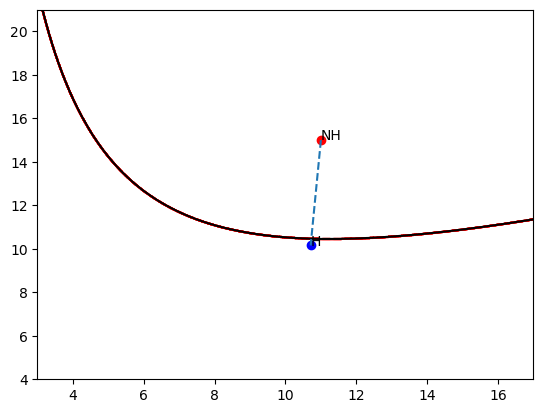

In [5]:
optimal_projection1 = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection1

     x1  x2
0   7.0  20
1   8.0  12
2   9.0  19
3  10.0  17
4  11.0  15
5  13.0  14
6  14.0  12
7  15.0  14
8  15.0  17
9  16.0  16
[1.05 1.05]
[-3.57288938 -0.6407448 ]
[1.05 1.05]
[-0.4127413  -0.69482652]
[1.05 1.05]
[-5.2099653 -1.2938909]
[1.05 1.05]
[-5.21218395 -2.30546576]
[1.05 1.05]
[-0.27054087 -4.52735398]
[1.05 1.05]
[ 0.51421018 -3.36582022]
[1.05 1.05]
[ 0.21448665 -1.2552767 ]
[1.05 1.05]
[ 0.72695907 -2.94918771]
[1.05 1.05]
[ 1.47636923 -5.77057428]
[1.05 1.05]
[ 0.9807346  -4.64298964]


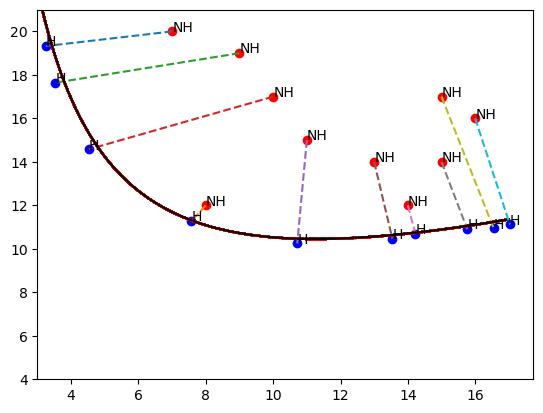

In [6]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
print(undesired_df)
optimal_datapts1 = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), epsilon=0.05)
    optimal_datapts1.loc[len(optimal_datapts1)] = optimal_pt

In [7]:
optimal_datapts1

,x1,x2
0,3.248466,19.327218
1,7.566622,11.270432
2,3.529536,17.641415
3,4.527207,14.579261
4,10.715932,10.246278
5,13.539921,10.465889
6,14.225211,10.681959
7,15.763307,10.903353
8,16.550188,10.940897
9,17.029771,11.124861


- The black line was generated from a set of points where the probability from the classifier matched 0.5 exactly or was sufficiently close to 0.5 (50%) 
- The red line was generated using the boundary function that we have defined above

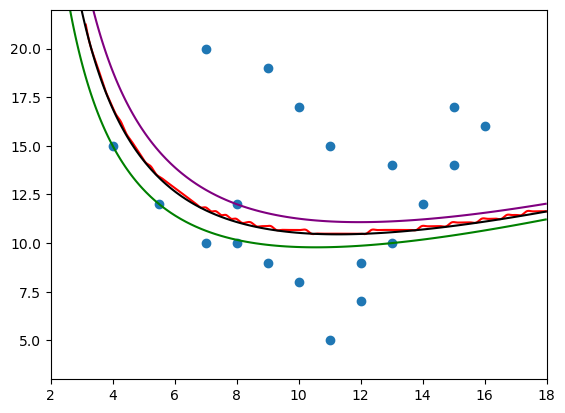

In [8]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
X=X_train

svm_classifier.fit(X_train, y_train)

X = X_train
x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 100),np.linspace(x2_min, x2_max, 100))
Z = svm_classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
x_in = np.c_[xx1.ravel(), xx2.ravel()]
y_pred = svm_classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx1.shape)

bound_data = []
contour = plt.contour(xx1, xx2, y_pred, colors='black')
for collection in contour.collections[:1]:
    for path in collection.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        bound_data.extend(zip(x_coords,y_coords))
for collection in contour.collections:
    collection.set_visible(False)
boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
N=200000
boundary_df = boundary_df.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
Y_pred = f(X_pred)
plt.plot(X_pred, Y_pred, c='r')
plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['purple','black','green'])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Applying Constraints on both $X_1$ and $X_2$ 

- Below, we apply the constraints to the magnitude of the direction vector from the original unhealthy point to the decision boundary 
- We apply the constraints independently for each feature $x_1$ and $x_2$ while fixing the other constraint. For instance, we fix $x_2$ feature while changing the scale factor for the direction of the $x_1$ feature. We also do this vice versa for the other feature.

Parameters: 
- Apply $\epsilon = 0.05$ and undesired coordinates $(11,15)$ 

First, we evaluate the ```optimal_point()``` function for the above parameters and get the optimal coordinates $(3.529, 17.641)$

[1.07 1.07]
[-0.27054087 -4.52735398]


array([10.71052127, 10.15573124])

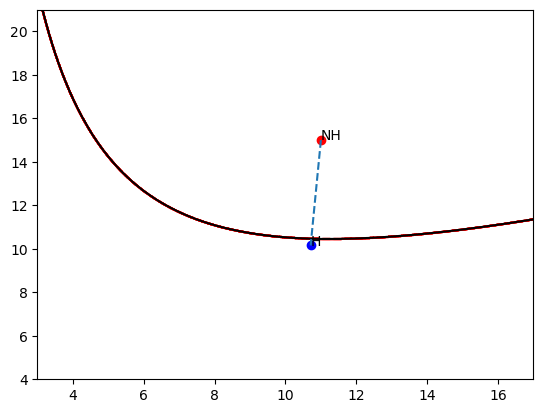

In [9]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection

We now fix the $x_2$ feature using the $x_2$ constraint variable and then change the $x_1$ feature across different scales, 5%, 10%, 15%, 20%, 25%.

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

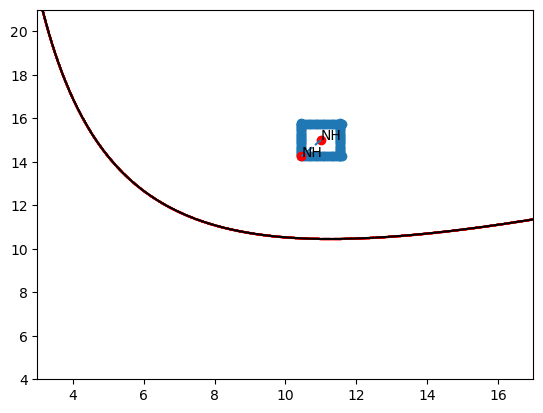

In [10]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-1.1  -0.75]


array([ 9.9 , 14.25])

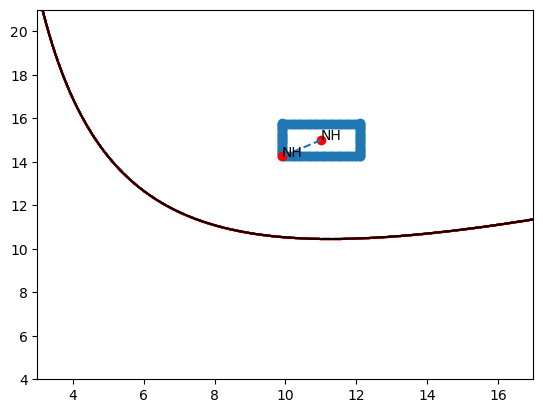

In [11]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=10, change_py=5)
optimal_projection

[1. 1.]
[-1.65 -0.75]


array([ 9.35, 14.25])

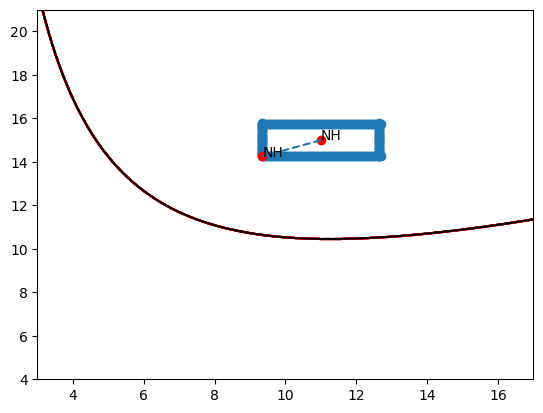

In [12]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=15, change_py=5)
optimal_projection

[1. 1.]
[-2.2  -0.75]


array([ 8.8 , 14.25])

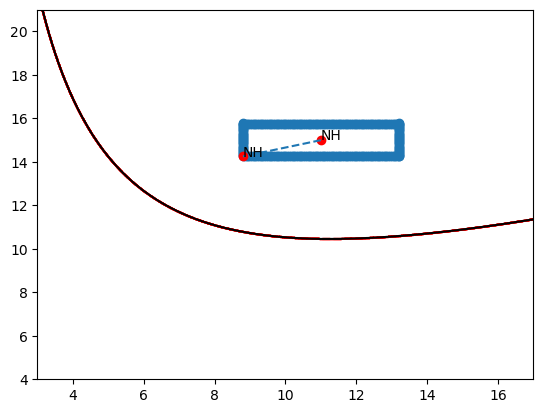

In [13]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=20, change_py=5)
optimal_projection

[1. 1.]
[-2.75 -0.75]


array([ 8.25, 14.25])

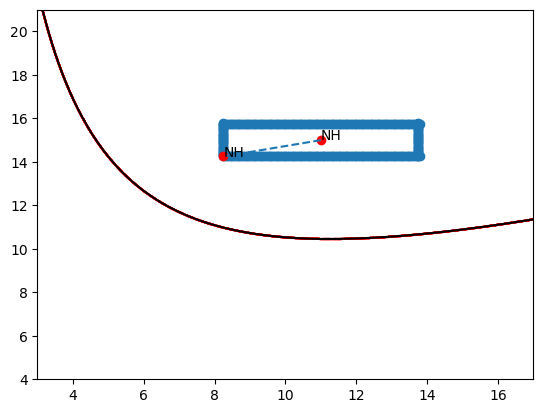

In [14]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=25, change_py=5)
optimal_projection

We now fix the $x_1$ feature using the $x_1$ constraint variable and then change the $x_2$ feature across different scales, 5%, 10%, 15%, 20%, 25%.

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

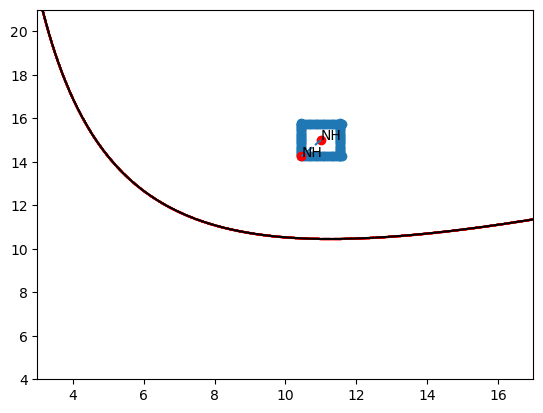

In [15]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-0.55 -1.5 ]


array([10.45, 13.5 ])

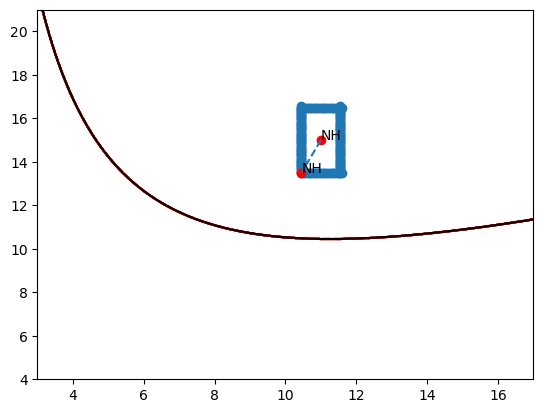

In [16]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=10)
optimal_projection

[1. 1.]
[-0.55 -2.25]


array([10.45, 12.75])

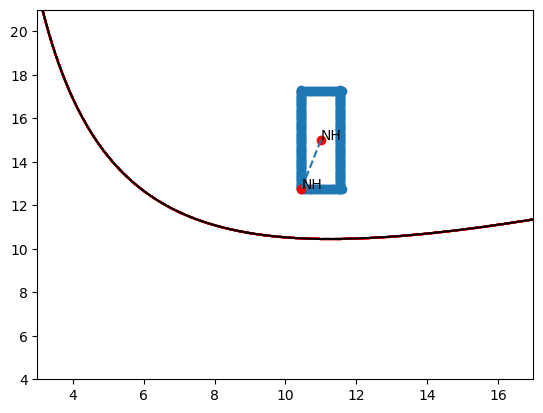

In [17]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=15)
optimal_projection

[1. 1.]
[-0.55 -3.  ]


array([10.45, 12.  ])

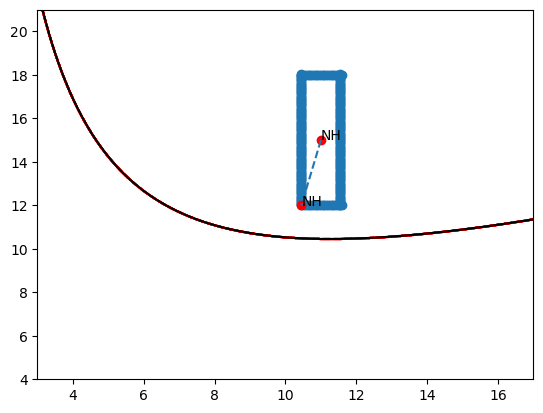

In [18]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=20)
optimal_projection

[1. 1.]
[-0.55 -3.75]


array([10.45, 11.25])

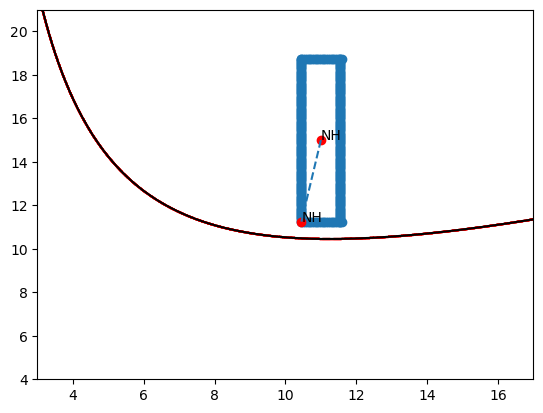

In [19]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=25)
optimal_projection

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

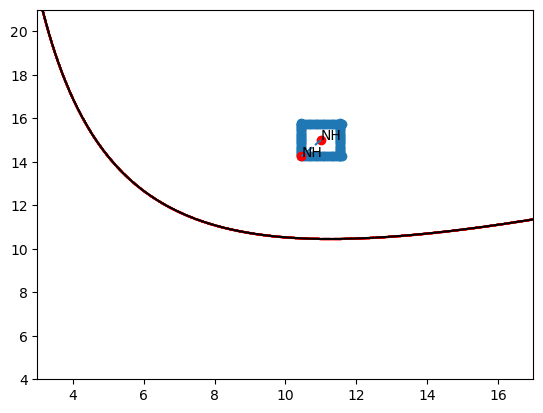

In [20]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-1.1 -1.5]


array([ 9.9, 13.5])

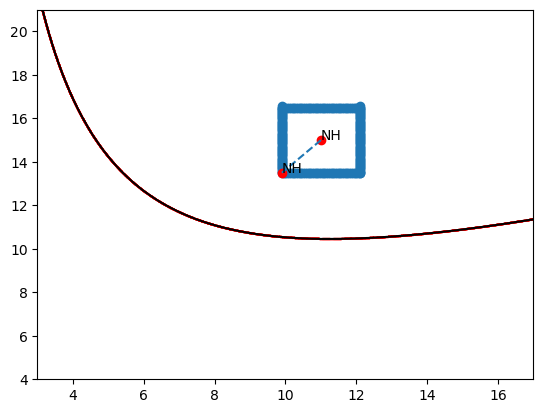

In [21]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=10, change_py=10)
optimal_projection

[1. 1.]
[-1.65 -2.25]


array([ 9.35, 12.75])

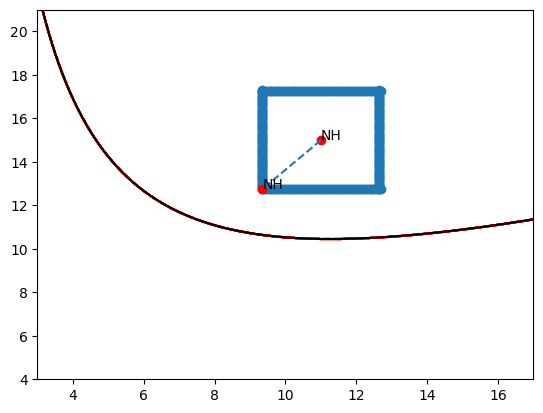

In [22]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=15, change_py=15)
optimal_projection

[1. 1.]
[-2.2 -3. ]


array([ 8.8, 12. ])

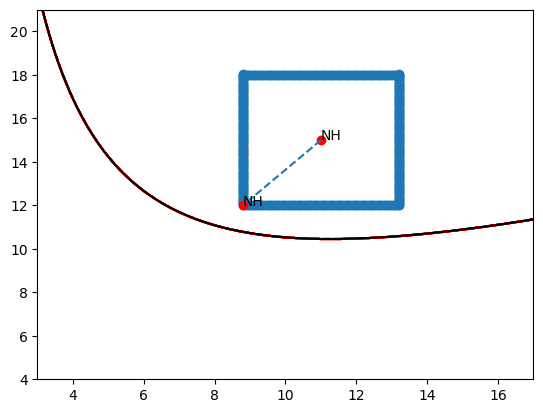

In [23]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=20, change_py=20)
optimal_projection

[1. 1.]
[ 3.3  -4.25]


array([14.3 , 10.75])

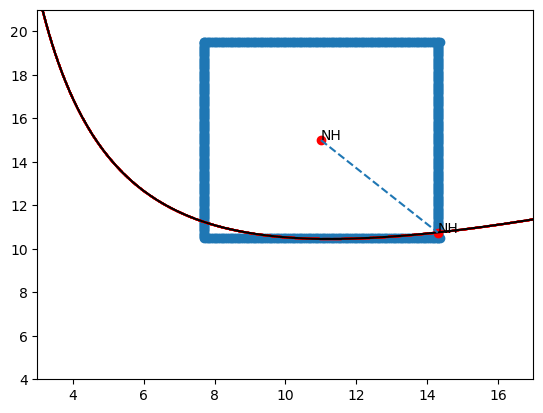

In [24]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=30, change_py=30)
optimal_projection

TypeError: change_px and change_py are both None

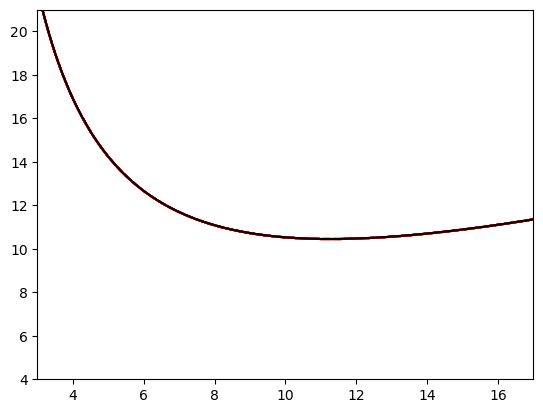

In [25]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px='inf', change_py='inf')

TypeError: change_px and change_py are both None

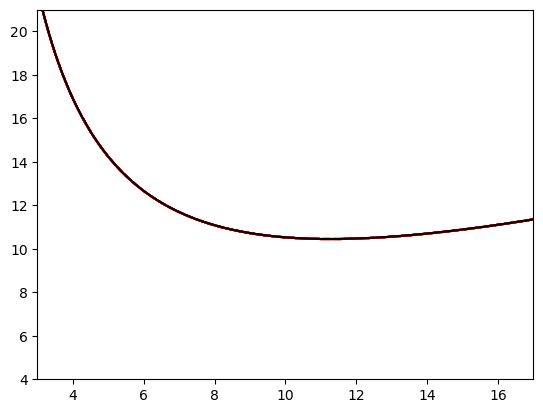

In [ ]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15))

[1. 1.]
[-0.27051198 -4.52735561]


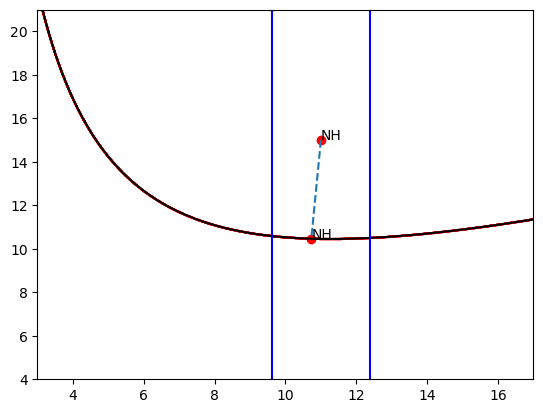

In [33]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=25, change_py=None)

[1. 1.]
[-0.27051198 -4.52735561]


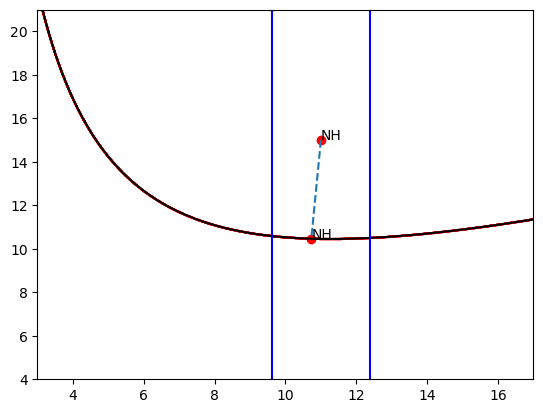

In [32]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=25, change_py='inf')

3.75
low bound and high bound
13.125 16.875
Index([   0,    4,   10,   16,   21,   27,   33,   38,   44,   50,
       ...
       3270, 3276, 3282, 3288, 3295, 3301, 3307, 3313, 3319, 3325],
      dtype='int64', length=669)
[1. 1.]
[-5.34562306 -1.875     ]


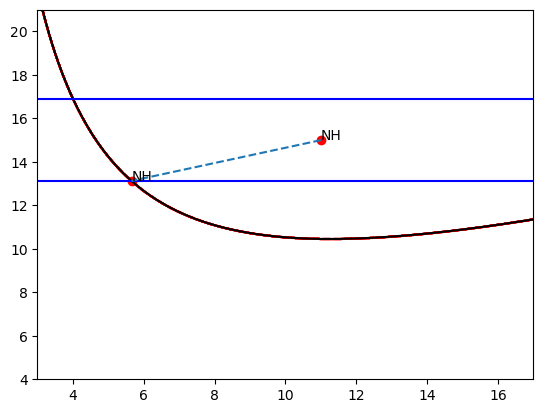

In [33]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px='inf', change_py=25)

3.75
low bound and high bound
13.125 16.875
Index([   0,    4,   10,   16,   21,   27,   33,   38,   44,   50,
       ...
       3270, 3276, 3282, 3288, 3295, 3301, 3307, 3313, 3319, 3325],
      dtype='int64', length=669)
[1. 1.]
[-5.34562306 -1.875     ]


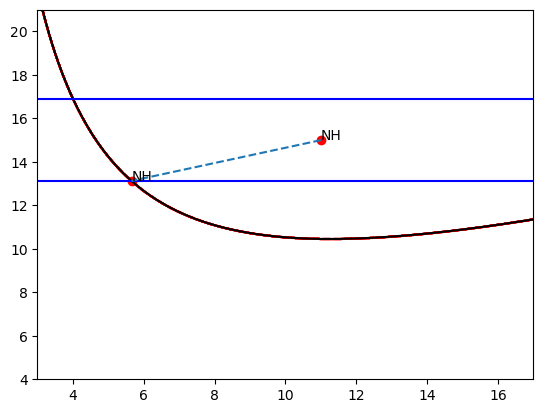

In [34]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=None, change_py=25)

# Synthetic Dataset Construction 

- Below, we construct a synthetic dataset consisting of three features. We have two features ```x1``` and ```x2``` and add a third feature to the SVM dataset for the sex of the patient.

In [34]:
import random 
random.seed(0)
synthetic_df = pd.read_csv('processed.cleveland.data')
synthetic_df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                        'fbs', 'restecg', 'thalach', 'exang',
                         'oldpeak', 'slope', 'ca', 'thal', 'num']
synthetic_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


# Removing Categorical Features 

- We remove all categorical features except for only categorical feature, namely the "sex" of the patient

In [36]:
cat_features_removed = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

synthetic_df = synthetic_df.drop(cat_features_removed, axis=1)
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,2
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,2
299,57.0,1.0,130.0,131.0,115.0,1.2,3
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [37]:
synthetic_df.loc[synthetic_df['num'] > 0, 'num'] = 1

In [38]:
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,1
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,1
299,57.0,1.0,130.0,131.0,115.0,1.2,1
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [39]:
from sklearn.model_selection import train_test_split 

X = synthetic_df.drop(columns='num')
y = synthetic_df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(241, 6) (61, 6) (241,) (61,)


In [40]:
X_train

,age,sex,trestbps,chol,thalach,oldpeak
132,51.0,1.0,140.0,261.0,186.0,0.0
202,64.0,0.0,140.0,313.0,133.0,0.2
196,45.0,0.0,138.0,236.0,152.0,0.2
75,60.0,1.0,125.0,258.0,141.0,2.8
176,56.0,1.0,132.0,184.0,105.0,2.1
...,...,...,...,...,...,...
188,69.0,1.0,140.0,254.0,146.0,2.0
71,62.0,1.0,120.0,267.0,99.0,1.8
106,57.0,1.0,128.0,229.0,150.0,0.4
270,66.0,1.0,160.0,228.0,138.0,2.3


In [41]:
duplicates = X_train.duplicated()
duplicates.any()

False

In [42]:
y_train

132    0
202    0
196    0
75     1
176    1
      ..
188    1
71     1
106    1
270    0
102    0
Name: num, Length: 241, dtype: int64

# Working with Categorical Features

- We want to generalize the decision boundary function for any $N$ number of features including $C$ categorical features. 
- We want to ensure that the search space is only $N-C$ whereas the model fits on the entire $N$ set of features. 

# Using the Synthetic Dataset 

- Below, we use the synthetic dataset constructed from three features (two from the original SVM dataset and one categorical variable for the sex of the patient) 
- As shown below, we return the optimal data point where we exclude the categorical feature "sex"

In [43]:
print(X_train.shape, y_train.shape)

(241, 6) (241,)


In [44]:
svm_classifier.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='poly', probability=True)

In [27]:
ranges = [np.linspace(X_train.iloc[:, j].min() - 0.25, X_train.iloc[:, j].max() + 0.25, 16) for j in range(X_train.shape[1])]
grids = np.meshgrid(*ranges) 

# Stack into a flat array of points (n_points^6 rows, 6 columns)
grid_points = np.vstack([g.ravel() for g in grids]).T

# # Convert to DataFrame with same column names (for consistency)
# # Grid points are not valid since sex is a categorical variable
grid_df = pd.DataFrame(grid_points, columns=X_train.columns)

grid_df

,age,sex,trestbps,chol,thalach,oldpeak
0,28.75,-0.25,93.75,125.75,70.75,-0.250000
1,28.75,-0.25,93.75,125.75,70.75,0.156667
2,28.75,-0.25,93.75,125.75,70.75,0.563333
3,28.75,-0.25,93.75,125.75,70.75,0.970000
4,28.75,-0.25,93.75,125.75,70.75,1.376667
...,...,...,...,...,...,...
16777211,77.25,1.25,192.25,564.25,202.25,4.223333
16777212,77.25,1.25,192.25,564.25,202.25,4.630000
16777213,77.25,1.25,192.25,564.25,202.25,5.036667
16777214,77.25,1.25,192.25,564.25,202.25,5.443333


In [28]:
sex_vector = [0 for _ in range(grid_df.shape[0]//2)]
sex_vector.extend([1 for _ in range(grid_df.shape[0]//2)])
# Add sex column vector (Random)
# Grid points must be a categorical value of 0 or 1 
grid_df['sex'] = sex_vector

In [29]:
# # Get probability predictions (ensure model outputs probabilities)
prob0 = svm_classifier.predict_proba(grid_df)[:, 0] 
prob1 = svm_classifier.predict_proba(grid_df)[:, 1] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 1E-6  # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
boundary_points_scaled = pd.DataFrame(grid_df[boundary_mask], columns=X_train.columns)
print(boundary_points_scaled)

            age  sex  trestbps        chol     thalach   oldpeak
130       28.75    0     93.75  125.750000  140.883333  0.563333
131       28.75    0     93.75  125.750000  140.883333  0.970000
132       28.75    0     93.75  125.750000  140.883333  1.376667
391       28.75    0     93.75  154.983333  140.883333  2.596667
392       28.75    0     93.75  154.983333  140.883333  3.003333
...         ...  ...       ...         ...         ...       ...
16776392  77.25    1    192.25  476.550000  175.950000  3.003333
16776645  77.25    1    192.25  505.783333  175.950000  1.783333
16776899  77.25    1    192.25  535.016667  175.950000  0.970000
16777152  77.25    1    192.25  564.250000  175.950000 -0.250000
16777153  77.25    1    192.25  564.250000  175.950000  0.156667

[111224 rows x 6 columns]


In [30]:
sex_vector = [1 for _ in range(grid_df.shape[0]//2)]
sex_vector.extend([0 for _ in range(grid_df.shape[0]//2)])
# Add sex column vector (Random)
# Grid points must be a categorical value of 0 or 1 
grid_df['sex'] = sex_vector

In [31]:
# Get probability predictions (ensure model outputs probabilities)
prob0 = svm_classifier.predict_proba(grid_df)[:, 0] 
prob1 = svm_classifier.predict_proba(grid_df)[:, 1] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 1E-3  # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
contour_pts = pd.DataFrame(grid_df[boundary_mask], columns=X_train.columns)
print(contour_pts)

            age  sex  trestbps        chol     thalach   oldpeak
129       28.75    1     93.75  125.750000  140.883333  0.156667
130       28.75    1     93.75  125.750000  140.883333  0.563333
131       28.75    1     93.75  125.750000  140.883333  0.970000
390       28.75    1     93.75  154.983333  140.883333  2.190000
391       28.75    1     93.75  154.983333  140.883333  2.596667
...         ...  ...       ...         ...         ...       ...
16776140  77.25    0    192.25  447.316667  175.950000  4.630000
16776393  77.25    0    192.25  476.550000  175.950000  3.410000
16776646  77.25    0    192.25  505.783333  175.950000  2.190000
16776900  77.25    0    192.25  535.016667  175.950000  1.376667
16777154  77.25    0    192.25  564.250000  175.950000  0.563333

[111224 rows x 6 columns]


In [32]:
contour_pts = contour_pts.drop_duplicates(subset=X_train.columns)

In [39]:
print(contour_pts.shape)

(13903, 6)


In [40]:
contour_pts = contour_pts.reset_index(drop=True)

contour_pts

,age,sex,trestbps,chol,thalach,oldpeak
0,28.75,1,93.75,125.750000,140.883333,0.156667
1,28.75,1,93.75,125.750000,140.883333,0.563333
2,28.75,1,93.75,125.750000,140.883333,0.970000
3,28.75,1,93.75,154.983333,140.883333,2.190000
4,28.75,1,93.75,154.983333,140.883333,2.596667
...,...,...,...,...,...,...
13898,77.25,0,192.25,447.316667,175.950000,4.630000
13899,77.25,0,192.25,476.550000,175.950000,3.410000
13900,77.25,0,192.25,505.783333,175.950000,2.190000
13901,77.25,0,192.25,535.016667,175.950000,1.376667


# Decision Boundary Points # 

If you want to extract the decision boundary points (not the plot) for a trained machine learning model with multiple features (e.g., 4 features), you can compute the decision boundary by evaluating the model's predictions on a grid of points in the feature space. The decision boundary is where the model's predicted class changes.
Here’s how you can compute the decision boundary points for a model with 4 features:
 

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression


In [3]:
import numpy as np 
X, y = make_classification(n_samples=1000, n_features=4, n_informative=4, n_redundant=0, random_state=42)
 
# Train a Logistic Regression model (or any other classifier)
model = LogisticRegression()
model.fit(X, y)

def compute_decision_boundary_points_cpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    boundary_points = []
 
    # Create a grid for all features
    grid = np.zeros((resolution ** n_features, n_features))
    for i, feature in enumerate(range(n_features)):
        np_array = np.linspace(X[:, feature].min() - 1, X[:, feature].max() + 1, resolution ** (n_features)).reshape(-1)
        grid[:, i] = np_array 

    # Predict the class for each point in the grid
    Z = model.predict(grid)
 
    # Find points near the decision boundary
    for i in range(len(grid) - 1):
        for j in range(i + 1, len(grid)):
            if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                boundary_points.append((grid[i] + grid[j]) / 2)  # Midpoint between two classes
 
    return np.array(boundary_points)

In [ ]:
# Compute decision boundary points considering all features
boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=12, epsilon=0.1)
 
# Print the decision boundary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
[[-0.59537255 -0.34083565 -0.32703044  0.25246708]
 [-0.59512088 -0.34058681 -0.3267609   0.25275028]
 [-0.59486922 -0.34033797 -0.32649137  0.25303347]
 ...
 [-0.54906595 -0.29504871 -0.27743642  0.30457496]
 [-0.54881428 -0.29479987 -0.27716689  0.30485815]
 [-0.54856262 -0.29455102 -0.27689736  0.30514134]]
(4465, 4)


In [9]:
print("Decision Boundary Points (Probability Across Both classes):")
model.predict_proba(boundary_points) 

Decision Boundary Points (Probability Across Both classes):


array([[0.50653839, 0.49346161],
       [0.50646862, 0.49353138],
       [0.50639885, 0.49360115],
       ...,
       [0.49369896, 0.50630104],
       [0.49362919, 0.50637081],
       [0.49355942, 0.50644058]])

In [ ]:
n_features = X.shape[1]
ranges = [np.linspace(X[:, j].min() - 1, X[:, j].max() + 1, 200) for j in range(n_features)]
grids = np.meshgrid(*ranges) 

grid_points = np.vstack([g.ravel() for g in grids]).T
print(grid_points.shape)

In [7]:
# Get probability predictions (ensure model outputs probabilities)
prob0 = model.predict_proba(grid_points)[:, 0] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 0.01 # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
print(grid_points[boundary_mask].shape)
print(model.predict_proba(grid_points[boundary_mask]))

(5659267, 4)
[[0.50561061 0.49438939]
 [0.50831424 0.49168576]
 [0.50310218 0.49689782]
 ...
 [0.49569818 0.50430182]
 [0.49048644 0.50951356]
 [0.49318987 0.50681013]]


In [ ]:
from scipy.interpolate import RBFInterpolator 
n_features = X.shape[1]
contour_pts = grid_points[boundary_mask]
X_vals, y_vals = contour_pts[:,0:n_features-1], np.reshape(contour_pts[:,-1], (-1,1)) 
print(y_vals.shape)
interpolator = RBFInterpolator(X, y, kernel='cubic', smoothing=1e-12, degree=3)

In [ ]:
# Compute decision boundary points considering all features
boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=25, epsilon=0.1)
 
# Print the decision boundary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

In [49]:
X, y = make_classification(n_samples=1000, n_features=4, n_informative=4, n_redundant=0, random_state=42)

# Train a Logistic Regression model (or any other classifier)
model = LogisticRegression()
model.fit(X, y)
 
boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=10, epsilon=0.1)
boundary_points = np.array(boundary_points)
print("Decision Boundary Points (All Features):")
print(boundary_points.shape)

KeyboardInterrupt: 

In [102]:
labels = model.predict(boundary_points)
labels = np.reshape(labels, (-1, 1))

labels.shape

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [110]:
from scipy.interpolate import griddata

n_features = X_train.shape[1]
ranges = [np.linspace(X_train[:, j].min() - 1, X_train[:, j].max() + 1, 100) for j in range(n_features)]
grids = np.meshgrid(*ranges)
new_points = np.random.rand(1000, n_features-1)
X, y = total_boundary_pts[:,0:n_features-1], boundary_points[:,-1] 
X, y = X.get(), y.get() 

interpolated_values = griddata(X, y, new_points, method='cubic')

ValueError: Unknown interpolation method 'cubic' for 3 dimensional data

# Constructing Final Function

- Uses the CPU version only (original version) 

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import RBFInterpolator


def multi_dim_interpolator(boundary_points): 
    X_vals, y_vals = boundary_points[:,0:boundary_points.shape[1]-1], boundary_points[:,-1]
    X_vals, y_vals = X_vals.get(), y_vals.get()

    interpolator = RBFInterpolator(X_vals,y_vals,kernel='gaussian', epsilon=10, smoothing=1e-10)
    return interpolator 

def compute_decision_boundary_points_cpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    boundary_points = []
 
    # Create a grid for all features
    grid = np.zeros((resolution ** n_features, n_features))
    for i, feature in enumerate(range(n_features)):
        np_array = np.linspace(X[:, feature].min() - 1, X[:, feature].max() + 1, resolution ** (n_features)).reshape(-1)
        grid[:, i] = np_array 

    # Predict the class for each point in the grid
    Z = model.predict(grid)
 
    # Find points near the decision boundary
    for i in range(len(grid) - 1):
        for j in range(i + 1, len(grid)):
            if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                boundary_points.append((grid[i] + grid[j]) / 2)  # Midpoint between two classes
 
    return np.array(boundary_points)

# Generates the decision boundary in the case of binary classification
def boundary_generator(model, X, resolution=10): 
    boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=resolution, epsilon=0.1)
    return boundary_points

# Gets boundary points
def boundary_points(model, X, resolution, epsilon): 
    boundary_df = boundary_generator(model, X, resolution=resolution, epsilon=epsilon)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

def get_border_points(x, y, delta_x, delta_y, step=0.1):
    points = []        
    
    # Define the boundaries
    x_min, x_max = x - delta_x, x + delta_x
    y_min, y_max = y - delta_y, y + delta_y

    # Generate points along the four edges
    for i in np.arange(x_min, x_max + step, step):
        points.append((i, y_min))  # Bottom edge
        points.append((i, y_max))  # Top edge

    for j in np.arange(y_min, y_max + step, step):
        points.append((x_min, j))  # Left edge
        points.append((x_max, j))  # Right edge

    # Remove duplicates (corner points get added twice)
    points = list(set(points))
    
    return points


# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def  optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, change_px=None, change_py=None, grid_epsilon=0.1, resolution=10): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip([df[col] for col in df.columns])))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    # Original grid for 2 dimensions
    # bound_x, bound_y = None, None
    # X = X_train
    # x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    # x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    boundary_pts = boundary_points(model=model, X=X_train, resolution=resolution, epsilon=grid_epsilon)

    # Original Interpolation for 2D
    # N = 200000
    # lower_boundx, upper_boundx = np.min(bound_x), np.max(bound_x)
    # f = interp1d(bound_x, bound_y, kind='cubic')
    # X_pred = np.linspace(lower_boundx, upper_boundx, N)[:, np.newaxis]
    # Y_pred = f(X_pred)
    # lower_boundy, upper_boundy = np.min(Y_pred), np.max(Y_pred)
    # interpolator = multi_dim_interpolator(boundary_points=boundary_pts)
    

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    if desired_class == 1: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        x,y = undesired_datapt[0], undesired_datapt[1]
        delta_x, delta_y = None, None 
        closest_boundedpt = None
        if (change_px is None and change_py is None) or (change_px == 'inf' and change_py == 'inf'): 
            raise TypeError("change_px and change_py are both None")
        elif change_px is None or change_px == 'inf': 
            delta_y = (change_py/100)*y
            print(delta_y)
            lowb_y, highb_y = max(y - (delta_y / 2), lower_boundy), min(y + (delta_y / 2), upper_boundy)
            print("low bound and high bound")
            print(lowb_y, highb_y) 
            plt.axhline(y=highb_y, color='b', linestyle='-', label='High Bound y')
            plt.axhline(y=lowb_y, color='b', linestyle='-', label='Low bound y')
            Y_pred_bound = np.linspace(lowb_y, highb_y, N)[:, np.newaxis]
            # Remove duplicates from y coordinates for boundary points
            bound_y_indices = bound_y.drop_duplicates().index 
            print(bound_y_indices) 
            f_inv = interp1d(bound_y.loc[bound_y_indices], bound_x.loc[bound_y_indices], kind='cubic')
            X_pred_bound = f_inv(Y_pred_bound) 
            bounded_contour_y = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_y)
            closest_boundedpt = closest_contourpt
        elif change_py is None or change_py == 'inf': 
            delta_x = (change_px/100)*x 
            lowb_x, highb_x = max(x - (delta_x/2), lower_boundx), min(x + (delta_x/2), upper_boundx)   
            plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
            plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            X_pred_bound = np.linspace(lowb_x, highb_x, N)[:, np.newaxis]
            Y_pred_bound = f(X_pred_bound) 
            bounded_contour_x = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_x)
            closest_boundedpt = closest_contourpt
        else: 
            delta_x, delta_y = (change_px/100)*x, (change_py/100)*y
            border_pts = get_border_points(x,y, delta_x, delta_y, step=0.05)
            deltas = np.array([delta_x, delta_y])
            x_values, y_values = zip(*border_pts)
            plt.scatter(x_values, y_values, marker='o')
            closest_borderpt = closest_border_point(border_pts, contour=contours)
            closest_boundedpt = closest_borderpt
        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt